In [1]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '600'})

In [2]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))

model.layers[-1].activation = None #keras.activations.relu




In [27]:
def kernel_grads(input_img, model, l_num, pred_idx=None)  :
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions

	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3):
				conv_layers.append(l)
				print(l.kernel_regularizer)

	last_conv_layer_name = conv_layers[l_num].name
	before_last_conv_layer_name = conv_layers[l_num-1].name

	grad_model = keras.models.Model(
		model.inputs, [model.get_layer(before_last_conv_layer_name).output, model.get_layer(last_conv_layer_name).output, model.output]
	)
	grad_model.get_layer(last_conv_layer_name).use_bias=False

	with tf.GradientTape(persistent=True) as tape:
		before_last_conv_layer_output, last_conv_layer_output, preds = grad_model(input_img, training=False)
		if pred_idx is None:
			pred_idx = tf.argmax(preds[0])
		print(tf.argmax(preds[0]))
		class_channel = preds[:, pred_idx]
	before_last_pooled_grads = tape.gradient(class_channel,  before_last_conv_layer_output)
	print(before_last_pooled_grads.shape)
	last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  last_conv_layer_output), axis=(0, 1, 2))
	#print(pooled_grads)

	print("LAST FEATURE : ", last_conv_layer_output.shape)
	top_k_filters = tf.math.top_k(last_pooled_grads, k=10)
	return before_last_pooled_grads, top_k_filters, last_conv_layer_output.numpy()


In [20]:
# Imagenet Validation Set location
img = "C:/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG"

In [21]:
train_list = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in train_labels], num_classes = 1000)


trainDS = Dataset.from_tensor_slices((train_list, train_labels))
trainDS = (trainDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)


val_list = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in val_list], num_classes = 1000)


valDS = Dataset.from_tensor_slices((val_list, val_labels))
valDS = (valDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)

In [22]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [23]:
l_num = -1


None
None
None
None
None
None
None
None
None
None
None
None
None
tf.Tensor(394, shape=(), dtype=int64)
(1, 14, 14, 512)
LAST FEATURE :  (1, 14, 14, 512)


'ax[1].imshow(feature[0,:,:,70])\nax[2].imshow(feature[0,:,:,topFilters.indices[0].numpy()])'

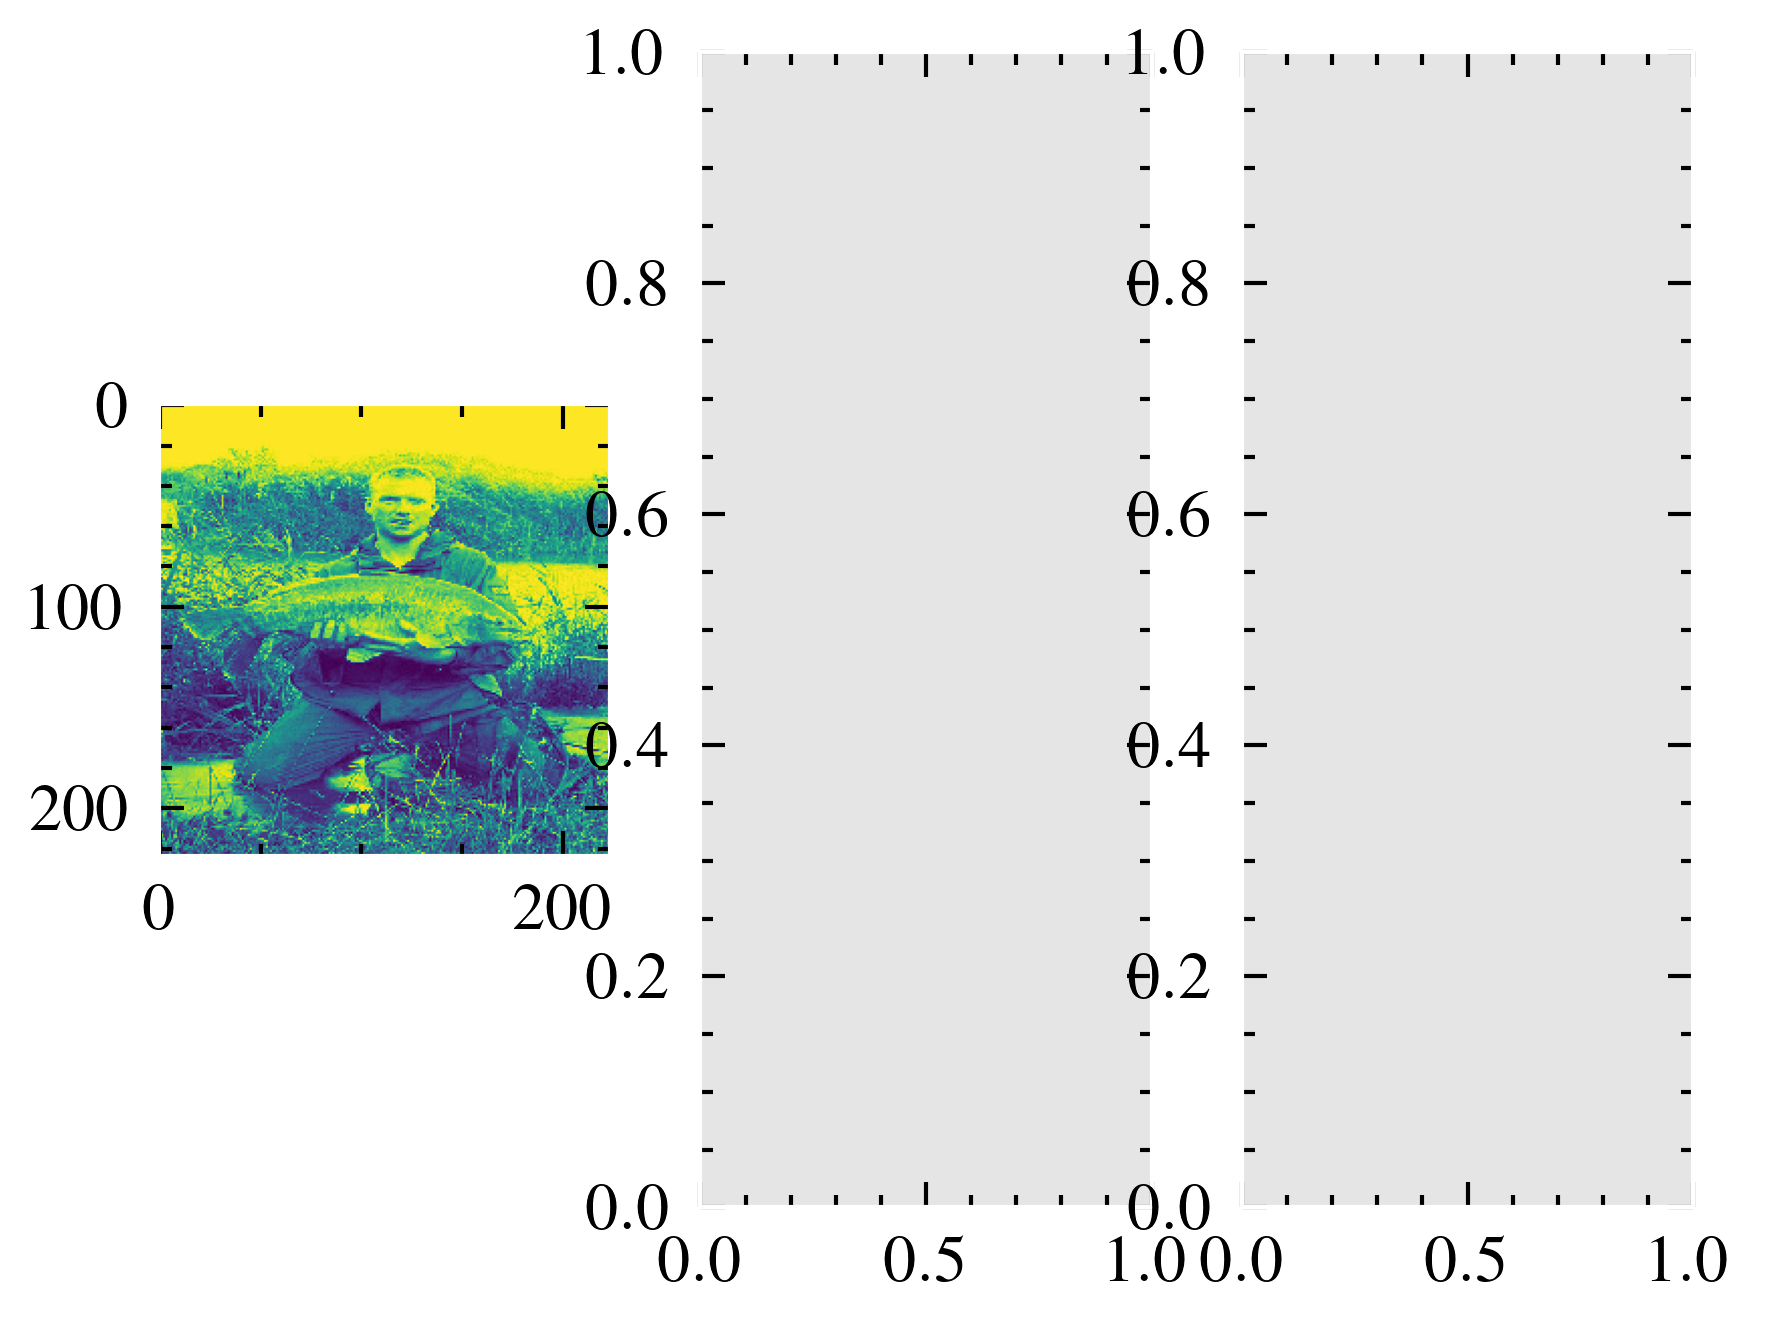

In [28]:
img = keras.applications.vgg16.preprocess_input(get_img_array(val_list[100], size=(224,224)))

pooled_grad, topFilters, feature = kernel_grads(img, model, l_num)
#pooled_grad = tf.math.reduce_mean(dy_dw, axis=(0,1))
feature.shape

fig , ax = plt.subplots(1,3)
ax[0].imshow(img[0,:,:,0])
'''ax[1].imshow(feature[0,:,:,70])
ax[2].imshow(feature[0,:,:,topFilters.indices[0].numpy()])'''


In [17]:
pooled_grad.shape

TensorShape([14, 512])

In [1]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '600'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

fig= plt.figure(figsize = (10,13))
fig.clf()
#fig.tight_layout()
gs1 = gridspec.GridSpec(1, 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss, projection='3d') for ss in gs1]
ax = np.reshape(ax, (1, 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)



#fig.set_tight_layout(True)
print(f" ============ LAYER {l_num} ==================")
top10F=  topFilters.indices.numpy() # topKfilters(model, l_num, k=5)   #    #
filters = get_filter(model, l_num)[:,:,:, top10F]
print(top10F)
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

mag = reduce_euclidean_norm(filters, axis=[0,1])
dc = np.sign(np.mean(filters, axis=(0,1)))
print(dc.shape)
#find lims :

for i in range(10):
	
	x =a_mag[:,i]*np.cos((theta[:,i]))
	y = a_mag[:,i]*np.sin((theta[:,i]))
	z = s_mag[:,i]*dc[:,i]
	lim_x = np.max(np.abs(x))
	lim_y = np.max(np.abs(y))
	lim_z = np.max(np.abs(z))
	lim = np.max([lim_x, lim_y, lim_z])
	#lim =np.max(np.abs(mag[:, i]))    
	lim*= 1.1

	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eig(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1
	#print(e_val, e_vec)

	#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
	ax[0, i].set_xlim(-lim, lim)
	ax[0, i].set_ylim(-lim, lim)
	ax[0, i].set_zlim(-lim, lim)

	color =  matplotlib.colors.TwoSlopeNorm(vcenter=0)(pooled_grad.numpy()[:, top10F[i]])
	#alpha =  matplotlib.colors.Normalize()(dy_dw_mag.numpy()[:, top10F[i]])
	try:
		ax[0, i].scatter(x,y,z, c=color, cmap="bwr",s=2)  
	except Exception as e:
		print(e)
		ax[0, i].scatter(x,y,z, c=color, cmap="bwr",s=2)  

	ax[0, i].view_init(-0,90)
	#ax[l_num, i].set_box_aspect((1,1,1))

	ax[0, i].set_xticks([])
	ax[0, i].set_yticks([])
	#ax[0, i].set_zticks([])

	#ax[l_num, i].set_aspect('equal')
	ax[0, i].collections[0].set_rasterized(True)

	#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	'''ax[l_num, i].annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))'''
	ax[0, i].set_xlabel(f"F{top10F[i]}", fontsize=7,) 
	ax[0, i].xaxis.set_label_position('top') 
	#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i in [-1]:
	
	ax[i, 0].set_ylabel(f"{conv_layers[i].name}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)


NameError: name 'plt' is not defined

In [10]:
alpha

NameError: name 'alpha' is not defined